### Import Libraries

In [282]:
# data wrangling
import pandas as pd
import numpy as np
import tweepy, string, emoji

In [283]:
# data exploration
from textblob import TextBlob
from wordcloud import WordCloud

In [284]:
# data cleaning
import nltk
from nltk.corpus import stopwords

### 1. Data Acquisition

In [285]:
# Twitter App access keys for the Twitter API

# Consume:
CONSUMER_KEY    = '42G7994DpZBgeoA3G0w2ihopW'
CONSUMER_SECRET = '0I0osePwJmyoweY1YmxiAwAf6zUQ2ewmmmRA59BM403XeXEcA2'

# Access:
ACCESS_TOKEN  = '1210220457363791872-Pq9hLTumRpww1R9biaJjGmtcuswHIT'
ACCESS_SECRET = '6zhJzN3c2FYVl8PPN5vRT9UnRWFEDdVlK3iUK3pbBWXgR'

In [286]:
def twitter_setup():
    
    # Authentication and access using user-specific keys
    authentication = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    authentication.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    # Return API with authentication
    api = tweepy.API(authentication)
    return api

In [287]:
# Create object to get tweets
get_tweets = twitter_setup()

# initialization to hold list of tweets
tweets = []

# Initial request : get most recent 200 tweets and print
# API.user_timeline : Returns the  most recent statuses posted from the authenticating user or the user specified. 
posts = get_tweets.user_timeline(screen_name = "netflix", count = 200)

# Method that takes an iterable such as list, tuple, string etc
# save the tweets 
tweets.extend(posts)

# How to get more than 200 tweets #

# Save the id of the oldest tweet, less one
oldest = tweets[-1].id - 1

# Keep getting tweets until there are no more- or in this case, until we reach the limit
# Return the length number of an object
while len(posts) > 0:

    # All subsequent requests use the max_id parameter, to prevent getting duplicates
    # max_id :  Returns only statuses with an ID less than (that is, older than) or equal to the specified ID.
    posts = get_tweets.user_timeline(screen_name = "netflix", count = 200, max_id = oldest)
    
    # Save most recent
    tweets.extend(posts)
    
    # Update id of the oldest tweet, less one
    oldest = tweets[-1].id - 1
    
    print("...%s tweets downloaded so far" % (len(tweets)))

print("Number of tweets extracted: {}.\n".format(len(tweets)))

# Print most recent just to check
print("Most recent 5 tweets:\n")
for tweet in tweets[:5]:
    print(tweet.text)
    print()


...399 tweets downloaded so far
...596 tweets downloaded so far
...794 tweets downloaded so far
...992 tweets downloaded so far
...1189 tweets downloaded so far
...1388 tweets downloaded so far
...1587 tweets downloaded so far
...1787 tweets downloaded so far
...1986 tweets downloaded so far
...2182 tweets downloaded so far
...2379 tweets downloaded so far
...2579 tweets downloaded so far
...2775 tweets downloaded so far
...2967 tweets downloaded so far
...3161 tweets downloaded so far
...3199 tweets downloaded so far
...3199 tweets downloaded so far
Number of tweets extracted: 3199.

Most recent 5 tweets:

No matter what kind of movie you want to watch tonight, Amy Adams has you covered: 

Hillbilly Elegy
Julie &amp; Julia… https://t.co/4tZteUabvk

RT @Netflix_CA: appreciation post for the flawless Catch Me If You Can opening credits https://t.co/04BQd97nii

@manuelaacolmee_ ❤️

Nicolas Cage screaming at an imaginary child named "Fucklyn" is truly something you must witness 

(📺: Hist

In [288]:
df = pd.DataFrame(data = [tweet.text for tweet in tweets], columns = ["tweet"])

In [289]:
df.head(10)

,tweet
0,No matter what kind of movie you want to watch...
1,RT @Netflix_CA: appreciation post for the flaw...
2,@manuelaacolmee_ ❤️
3,Nicolas Cage screaming at an imaginary child n...
4,RT @Mike_Eagle: catch me on what my family is ...
5,"I hear we’re getting drivers licenses, fellow ..."
6,@lanacondor already 😭😭
7,RT @lanacondor: THE TO ALL THE BOYS 3 TRAILER ...
8,@abigailbarloww you are blowing all of our min...
9,Absolutely blown away by the Bridgerton musica...


### 2. Data Cleaning and Pre-processing

#### 2.1 Remove Stopwords and Punctuations

In [290]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [291]:
from nltk.corpus import stopwords

In [292]:
stopwords = stopwords.words("english")

In [293]:
stopwords += list(string.punctuation)

In [294]:
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [295]:
def preprocessing(posts):
    posts = str(posts).lower()
    posts = re.sub(r"@[A-Za-z0-9_]+", "", posts) #r- represent raw string
    posts = re.sub(r":", "", posts) #@username:, "...:"
    posts = re.sub(r"rt[\s]", "", posts)
    posts = re.sub(r"https?\/\/\S+", "", posts)
    posts = posts.replace("\n", "")
    posts = posts.replace('"', "")
    posts = posts.replace('', "")
    #posts = " ".join([item for item in str(posts).split() if item not in stopwords])- high memory
    tokens = nltk.word_tokenize(posts)
    posts = [token.lower() for token in tokens if token.lower() not in stopwords]
    return posts

In [296]:
df["tweet"] = df["tweet"].apply(preprocessing)

Reverse tokenization in order to extract more than one emojis in a sentence.

In [297]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [298]:
def detokenized(posts):
    posts = TreebankWordDetokenizer().detokenize(posts)
    return posts

In [299]:
df["tweet"] = df["tweet"].apply(detokenized)

In [300]:
df.head(10)

,tweet
0,matter kind movie want watch tonight amy adams...
1,appreciation post flawless catch opening credits
2,❤️
3,nicolas cage screaming imaginary child named f...
4,catch family calling 'the cussing show history...
5,hear ’ getting drivers licenses fellow kids…
6,already 😭😭
7,boys 3 trailer finally ready 😍😭😍😭 boys always ...
8,blowing minds's happening
9,absolutely blown away bridgerton musical playi...


#### 2.2 Create Emoji Column

Extract emoji from every sentence using emoji.UNICODE_EMOJI.

In [301]:
def extract_emojis(posts):
    return ''.join(c for c in posts if c in emoji.UNICODE_EMOJI)

In [302]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [303]:
df.head(50)

,tweet,emoji
0,matter kind movie want watch tonight amy adams...,
1,appreciation post flawless catch opening credits,
2,❤️,❤
3,nicolas cage screaming imaginary child named f...,📺
4,catch family calling 'the cussing show history...,
5,hear ’ getting drivers licenses fellow kids…,
6,already 😭😭,😭😭
7,boys 3 trailer finally ready 😍😭😍😭 boys always ...,😍😭😍😭
8,blowing minds's happening,
9,absolutely blown away bridgerton musical playi...,


Remove emoji in a sentence after creating an emoji column.

In [304]:
def remove_emojis(posts):
    pattern = "[@!\w]+"
    return ' '.join(re.findall(pattern, posts))

In [305]:
df['tweet'] = df.tweet.apply(remove_emojis)

Check for missing values in emoji column.

In [306]:
df.emoji.isna().sum()

0

Count number of emoji in a sentence and create a new column.

In [308]:
def unique_emoji_count(posts):
    return len(set([c for c in posts]))

In [309]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [310]:
df.head(10)

,tweet,emoji,unique_emoji_count
0,matter kind movie want watch tonight amy adams...,,0
1,appreciation post flawless catch opening credits,,0
2,,❤,1
3,nicolas cage screaming imaginary child named f...,📺,1
4,catch family calling the cussing show history ...,,0
5,hear getting drivers licenses fellow kids,,0
6,already,😭😭,1
7,boys 3 trailer finally ready boys always forev...,😍😭😍😭,2
8,blowing minds s happening,,0
9,absolutely blown away bridgerton musical playi...,,0


Compute the sentiment score using vaderSentiment.vadeerSentiment library

In [311]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(posts):
    return analyzer.polarity_scores(posts)['compound']

In [312]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [313]:
df.head(10)

,tweet,emoji,unique_emoji_count,sentiment_score
0,matter kind movie want watch tonight amy adams...,,0,0.5859
1,appreciation post flawless catch opening credits,,0,0.8442
2,,❤,1,0.0000
3,nicolas cage screaming imaginary child named f...,📺,1,0.0772
4,catch family calling the cussing show history ...,,0,0.0258
5,hear getting drivers licenses fellow kids,,0,0.0000
6,already,😭😭,1,0.0000
7,boys 3 trailer finally ready boys always forev...,😍😭😍😭,2,0.3612
8,blowing minds s happening,,0,0.0000
9,absolutely blown away bridgerton musical playi...,,0,0.2023


Compute the usage of excalamation point in a sentence. The excalamation remarks can either show excitement, frustration or anger.

In [314]:
from tqdm import tqdm
tqdm.pandas()

c:\users\acer\appdata\local\programs\python\python38-32\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [315]:
def exclamation_percentage(posts):
    count = np.char.count(posts, sub ='!').sum()
    return count / len(posts)

In [316]:
df['exclamation_points'] = df.tweet.progress_apply(exclamation_percentage)

100%|███████████████████████████████████████████████████████████████████████████| 3199/3199 [00:00<00:00, 52445.60it/s]


In [317]:
df.head(10)

,tweet,emoji,unique_emoji_count,sentiment_score,exclamation_points
0,matter kind movie want watch tonight amy adams...,,0,0.5859,0.0
1,appreciation post flawless catch opening credits,,0,0.8442,0.0
2,,❤,1,0.0000,NaN
3,nicolas cage screaming imaginary child named f...,📺,1,0.0772,0.0
4,catch family calling the cussing show history ...,,0,0.0258,0.0
5,hear getting drivers licenses fellow kids,,0,0.0000,0.0
6,already,😭😭,1,0.0000,0.0
7,boys 3 trailer finally ready boys always forev...,😍😭😍😭,2,0.3612,0.0
8,blowing minds s happening,,0,0.0000,0.0
9,absolutely blown away bridgerton musical playi...,,0,0.2023,0.0


Check for missing values in other columns.

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet               3199 non-null   object 
 1   emoji               3199 non-null   object 
 2   unique_emoji_count  3199 non-null   int64  
 3   sentiment_score     3199 non-null   float64
 4   exclamation_points  3079 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 100.0+ KB


exclamation_points column has several missing values, therefore, the missing values will be imputed by using mean value.

In [319]:
pd.options.mode.chained_assignment = None  # default='warn'

In [320]:
average_exclamationpoints = df["exclamation_points"].mean()

In [321]:
df["exclamation_points"][np.isnan(df["exclamation_points"])] = average_exclamationpoints

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet               3199 non-null   object 
 1   emoji               3199 non-null   object 
 2   unique_emoji_count  3199 non-null   int64  
 3   sentiment_score     3199 non-null   float64
 4   exclamation_points  3199 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 100.0+ KB


Filter no-emoji data.

In [323]:
df = df[df.unique_emoji_count > 0]

In [324]:
df.reset_index(inplace = True)

In [325]:
df.head(10)

,index,tweet,emoji,unique_emoji_count,sentiment_score,exclamation_points
0,2,,❤,1,0.0000,0.0
1,3,nicolas cage screaming imaginary child named f...,📺,1,0.0772,0.0
2,6,already,😭😭,1,0.0000,0.0
3,7,boys 3 trailer finally ready boys always forev...,😍😭😍😭,2,0.3612,0.0
4,11,already love show mean god sake lupin,🖤🖤🖤,1,0.7430,0.0
5,15,meet parineeti chopra s girl train director s ...,🚆,1,0.1027,0.0
6,18,puggerton,🐝,1,0.0000,0.0
7,25,know rakes brush regency slang cast bridgerton,👀,1,0.0000,0.0
8,33,set reminder tomorrow big news share,👉,1,0.2960,0.0
9,34,said needed riskyairlines lying chris rock tot...,👀,1,-0.6705,0.0


Count number of times used for every emoji.

In [326]:
df[(df.emoji.apply(len) == 1)].emoji.value_counts()[:30]

📺    36
❤    16
🎥    10
🥺     9
👀     9
💜     9
🤍     7
📽     7
😍     7
✨     6
🔥     5
🖤     5
🗣     4
😭     4
🤝     4
💕     3
👑     3
😂     3
💛     3
🥰     3
📸     3
📷     3
🤩     2
💞     2
🔎     2
💝     2
♟     2
🤣     2
☂     2
🌑     2
Name: emoji, dtype: int64

Define the emoji's expressions.

In [327]:
chill = ['📺']

In [328]:
sad = ['😩','😢','😫','😓','😟','🙁','😞', '😔', '😣', '😭']

In [329]:
fearful = [ '😱', '😰','😨'] 

In [330]:
angry = ['😡','😠','🤬']

In [331]:
happy = ['😊','🤗','😁','😌','😀','🙂','😄', '❤', '💜', '🤍', '🥰']

In [332]:
excited = ['👀', '😍', '😻', '😙', '👏']

In [333]:
annoyed = ['😒', '😑']

Condence multiple emojis exists in a sentence by using pop() function when raising the exception (-> only a single emoji).

In [334]:
def condence_emojis(posts):
    try:
        return set(posts).pop()
    except:
        return None

Create a dummy dataframe using copy() function to calculate the mean of emoji's sentiment score.

In [335]:
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

Compute top emoji based on its sentiment score.

In [336]:
def impute_top_emoji(posts, mappings = emoji_sentiment_mappings, data = df):
    # Refer the emoji to the respective posts ("tweet")
    # Intialize the value as the sentiment_score of the first row
    val = df[df.emoji == posts].sentiment_score.values[0]
    
    # Assign posts ("tweet") to a list
    posts = list(set(posts))
    
    # Assign a dummy value
    closest = 100
    
    # Initialize the top sentiment_score
    top = posts[0]
    
    for i in range(0, len(posts)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[posts[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[posts[i]].sentiment_score)
                top = posts[i]
        except:
            continue
    return top

In [337]:
df['top_emoji'] = df.emoji.progress_apply(impute_top_emoji)

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 916.67it/s]


In [338]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)

In [339]:
df.drop(["index"], axis=1, inplace=True)

In [340]:
df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji
0,,0.0000,0.0,❤
1,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺
2,already,0.0000,0.0,😭
3,boys 3 trailer finally ready boys always forev...,0.3612,0.0,😍
4,already love show mean god sake lupin,0.7430,0.0,🖤
5,meet parineeti chopra s girl train director s ...,0.1027,0.0,🚆
6,puggerton,0.0000,0.0,🐝
7,know rakes brush regency slang cast bridgerton,0.0000,0.0,👀
8,set reminder tomorrow big news share,0.2960,0.0,👉
9,said needed riskyairlines lying chris rock tot...,-0.6705,0.0,👀


Compute the number of times or frequency of emoji has been used.

In [342]:
emoji_counts = dict(df.top_emoji.value_counts()) #key-value: emoji-count

In [343]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [344]:
df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency
0,,0.0000,0.0,❤,28
1,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺,36
2,already,0.0000,0.0,😭,13
3,boys 3 trailer finally ready boys always forev...,0.3612,0.0,😍,12
4,already love show mean god sake lupin,0.7430,0.0,🖤,10
5,meet parineeti chopra s girl train director s ...,0.1027,0.0,🚆,1
6,puggerton,0.0000,0.0,🐝,1
7,know rakes brush regency slang cast bridgerton,0.0000,0.0,👀,11
8,set reminder tomorrow big news share,0.2960,0.0,👉,1
9,said needed riskyairlines lying chris rock tot...,-0.6705,0.0,👀,11


Save the data.

In [345]:
df.to_csv("emoji sentiment.csv")

Plot sentiment score for an overview.

In [346]:
import seaborn as sns

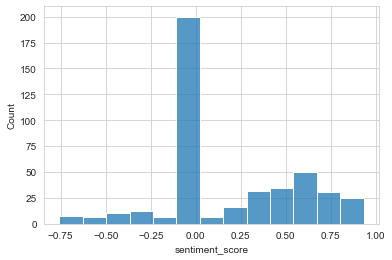

In [347]:
sns.histplot(df.sentiment_score)

Potray sentiment score overview.

In [349]:
print("Sentiments for chill")
for i in range(0,len(chill)):
    print(df[df.top_emoji==chill[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for sad")
for i in range(0,len(sad)):
    print(df[df.top_emoji==sad[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for fearful")
for i in range(0,len(fearful)):
    print(df[df.top_emoji==fearful[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for angry")
for i in range(0,len(angry)):
    print(df[df.top_emoji==angry[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for happy")
for i in range(0,len(happy)):
    print(df[df.top_emoji==happy[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for excited")
for i in range(0,len(excited)):
    print(df[df.top_emoji==excited[i]].sentiment_score.mean()) 
print("----------------------")
print("Sentiments for annoyed")
for i in range(0,len(annoyed)):
    print(df[df.top_emoji==annoyed[i]].sentiment_score.mean())

Sentiments for chill
0.16259722222222223
----------------------
Sentiments for sad
nan
0.296
nan
nan
nan
nan
nan
nan
nan
0.11638461538461538
----------------------
Sentiments for fearful
0.0
nan
nan
----------------------
Sentiments for angry
nan
nan
nan
----------------------
Sentiments for happy
nan
0.4588
0.2732
-0.5574
nan
nan
0.6369
0.2903857142857143
0.07771666666666664
0.3237076923076923
0.5691333333333334
----------------------
Sentiments for excited
-0.09379090909090909
0.3056083333333333
nan
nan
0.142575
----------------------
Sentiments for annoyed
nan
nan


Filter emoji based on the defined expressions.

In [350]:
all_e = chill + sad + fearful + angry + happy + excited + annoyed

In [351]:
new_df = df[df.top_emoji.isin(all_e)]

Create a dictionary for defined emoji-expression and its count to be assigned to exsiting "emoji_frequency" column.

In [352]:
conditions = [
    new_df.top_emoji.isin(chill[1:]),
    new_df.top_emoji.isin(sad[1:]),
    new_df.top_emoji.isin(fearful[1:]),
    new_df.top_emoji.isin(angry[1:]),
    new_df.top_emoji.isin(happy[1:]),
    new_df.top_emoji.isin(excited[1:]),
    new_df.top_emoji.isin(annoyed[1:])
    
]

choices = [
    chill[0],
    sad[0],
    fearful[0],
    angry[0], 
    happy[0],
    excited[0],
    annoyed[0]
]

new_df.top_emoji = np.select(conditions, choices, default = new_df.top_emoji)

In [353]:
new_df.top_emoji.value_counts()

😊    66
👀    39
📺    36
😩    14
😱     2
Name: top_emoji, dtype: int64

In [354]:
new_df.drop('emoji_frequency', axis=1, inplace=True)
freq_map = dict(new_df.top_emoji.value_counts())
new_df['emoji_frequency'] = new_df.top_emoji.map(freq_map)

new_df.to_csv("tweets_4_classes.csv")

In [355]:
emojis = new_df.groupby('top_emoji').mean()
emojis.to_csv("emojis_NEW.csv")

In [356]:
emojis

,sentiment_score,exclamation_points,emoji_frequency
top_emoji,,,
👀,0.126072,0.0,39
📺,0.162597,0.0,36
😊,0.290989,0.0,66
😩,0.129214,0.0,14
😱,0.000000,0.0,2


### 3. Data Exploration and Visualization

#### Emoji Comparison

Plot the emoji according to its count and sentiment score.

In [357]:
# Download emoji.png
pics = ["image/excited.png", "image/chill.png", "image/happy.png", "image/sad.png", "image/fearful.png"]

In [358]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [359]:
def getImage(path):
    return OffsetImage(plt.imread(path, 0))

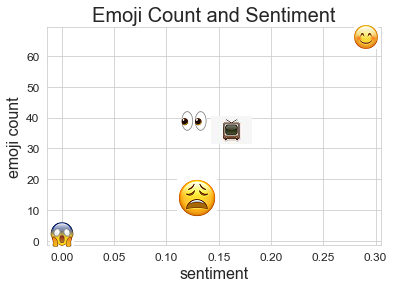

In [360]:
fig, ax = plt.subplots(figsize = (6,4))

sns.scatterplot(x=emojis.sentiment_score, y=emojis.emoji_frequency, ax=ax)
sns.set_style("whitegrid")
plt.xticks(fontsize=12)
plt.xlabel('sentiment', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('emoji count', fontsize=16)
plt.title("Emoji Count and Sentiment", fontsize = 20)

for x0, y0, pic in zip(emojis.sentiment_score, emojis.emoji_frequency,pics):
    ab = AnnotationBbox(getImage(pic), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.savefig('image/emoji_count_and_sentiment.png')
plt.show()

Compute the subjectivity of the tweet based on the top emoji (in new_df).

In [361]:
def get_subjectivity(posts):
    b = TextBlob(posts)
    return b.sentiment.subjectivity

In [362]:
new_df['subjectivity'] = new_df.tweet.progress_apply(get_subjectivity)

100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 1097.90it/s]


In [363]:
emoji_counts = dict(new_df.top_emoji.value_counts())

In [364]:
new_df['emoji_frequency'] = new_df.top_emoji.map(emoji_counts)

In [365]:
new_df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency,subjectivity
0,,0.0000,0.0,😊,66,0.000000
1,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺,36,0.000000
2,already,0.0000,0.0,😩,14,0.000000
3,boys 3 trailer finally ready boys always forev...,0.3612,0.0,👀,39,0.500000
7,know rakes brush regency slang cast bridgerton,0.0000,0.0,👀,39,0.000000
9,said needed riskyairlines lying chris rock tot...,-0.6705,0.0,👀,39,0.750000
10,amanda larusso exactly kind smart strong carin...,0.9325,0.0,📺,36,0.631548
22,one regé jean page bridgerton,0.0000,0.0,👀,39,0.000000
23,,0.0000,0.0,😊,66,0.000000
24,,0.0000,0.0,👀,39,0.000000


Create wordcloud from the emoji's expressions.

In [366]:
from nltk.probability import FreqDist

In [370]:
def make_word_cloud(new_df, emoji, emoji_expression):
    df_freq = new_df[new_df['top_emoji']==emoji]
    data = df_freq['tweet']
    processed = list(map(preprocessing, data))
    
    #flat = [item.split() for item in processed]- the data were already in list
    flat_2 = []
    for row in processed:
        for word in row:
            flat_2.append(word)
    freq = FreqDist(flat_2)
    
    # Top 40 most common words
    bar_counts = [x[1] for x in freq.most_common(40)]
    bar_words = [x[0] for x in freq.most_common(40)]
    
    dictionary = dict(zip(bar_words, bar_counts))
    
    # Create the word cloud:
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)
    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(6,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    plt.show()

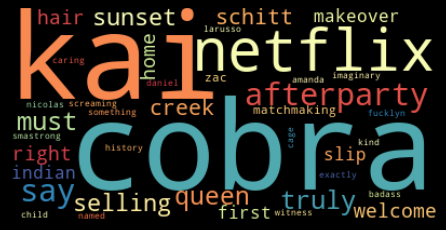

In [371]:
make_word_cloud(new_df, '📺', 'chill')

In [372]:
for item in new_df[new_df.top_emoji == '📺'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')

nicolas cage screaming imaginary child named fucklyn truly something must witness history s
-----------------------------------------------------------------------------------------------------
amanda larusso exactly kind smart strong caring badass daniel would married cobra kai
-----------------------------------------------------------------------------------------------------
problem bridgerton
-----------------------------------------------------------------------------------------------------
cobra kai star mary mouser unique rule comes on screen kisses netflix afterparty
-----------------------------------------------------------------------------------------------------
love queen loves gossip
-----------------------------------------------------------------------------------------------------
selling sunset s secret weapon revealed netflix afterparty
-----------------------------------------------------------------------------------------------------
think agree arón piper mess

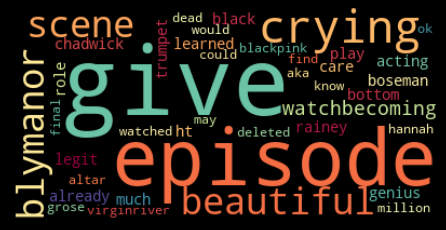

In [373]:
make_word_cloud(new_df, '😩', 'sad')

In [374]:
for item in new_df[new_df.top_emoji == '😩'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')

already
-----------------------------------------------------------------------------------------------------
chadwick boseman legit learned play trumpet role rainey s black bottom acting genius ht
-----------------------------------------------------------------------------------------------------
crying crying
-----------------------------------------------------------------------------------------------------
care much s beautiful virginriver
-----------------------------------------------------------------------------------------------------
ok final blackpink deleted scene know would give million could find s r
-----------------------------------------------------------------------------------------------------
watched altar dead aka hannah grose episode blymanor may never emotionally recover give a
-----------------------------------------------------------------------------------------------------
omfg give t nia miller emmys thehauntingofblymanor blymanor blymanorwatchparty
---

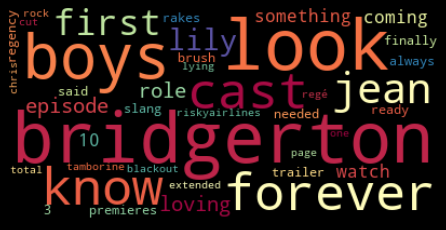

In [375]:
make_word_cloud(new_df, '👀', 'excited')

In [376]:
for item in new_df[new_df.top_emoji == '👀'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')

boys 3 trailer finally ready boys always forever premieres
-----------------------------------------------------------------------------------------------------
know rakes brush regency slang cast bridgerton
-----------------------------------------------------------------------------------------------------
said needed riskyairlines lying chris rock total blackout tamborine extended cut d
-----------------------------------------------------------------------------------------------------
one regé jean page bridgerton
-----------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------
phoebedynevor bridgerton
-----------------------------------------------------------------------------------------------------
hey thanks bridgerton love
-----------------------------------------------------------------------------------------------------

-------------

#### Sentiment Analysis

In [381]:
new_df.groupby('top_emoji').mean().sentiment_score

top_emoji
👀    0.126072
📺    0.162597
😊    0.290989
😩    0.129214
😱    0.000000
Name: sentiment_score, dtype: float64

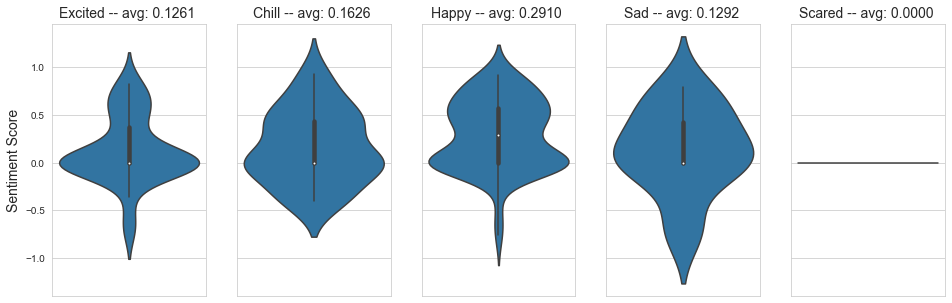

In [382]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,5), sharey=True, )
titles = ['Excited', 'Chill', 'Happy', 'Sad', 'Scared']

# Plot the mean of sentiment score
for i, emoji in enumerate(new_df.groupby('top_emoji').mean().sentiment_score.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].sentiment_score, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].sentiment_score.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Sentiment Score", fontsize=14)
    else:
        axes[i].set_ylabel("")

plt.show()

#### Subjectivity

In [275]:
new_df.groupby('top_emoji').mean().subjectivity

top_emoji
👀    0.221970
📺    0.312028
😊    0.319625
😩    0.450463
😱    0.000000
Name: subjectivity, dtype: float64

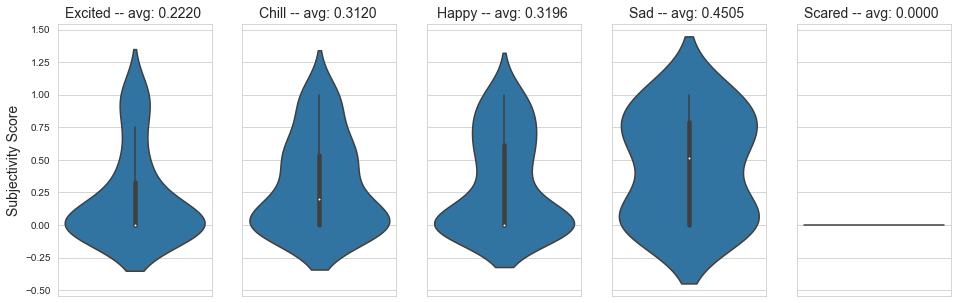

In [276]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,5), sharey=True, )
titles = ['Excited', 'Chill', 'Happy', 'Sad', 'Scared']

# Plot the mean of subjectivity
for i, emoji in enumerate(new_df.groupby('top_emoji').mean().subjectivity.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].subjectivity, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].subjectivity.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)    
    if i == 0:
        axes[i].set_ylabel("Subjectivity Score", fontsize=14)
    else:
        axes[i].set_ylabel("")

plt.show()

#### Exclamation Points

In [277]:
new_df.groupby('top_emoji').mean().exclamation_points

top_emoji
👀    0.0
📺    0.0
😊    0.0
😩    0.0
😱    0.0
Name: exclamation_points, dtype: float64

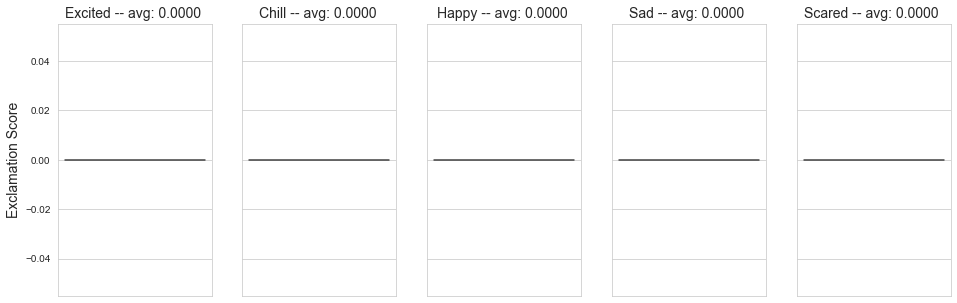

In [278]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,5), sharey=True, )
titles = ['Excited', 'Chill', 'Happy', 'Sad', 'Scared']

# Plot the mean of exclamation point
for i, emoji in enumerate(new_df.groupby('top_emoji').mean().exclamation_points.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].exclamation_points, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].exclamation_points.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Exclamation Score", fontsize=14)
    else:
        axes[i].set_ylabel("")

plt.show()